# Project Statement

## Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log
returns of a stock/index are normally distributed.

Investigate if the log returns of stocks or indexes of your choosing are
normally distributed. Some suggestions for exploration include:

1.  Test if there are period of times when the log-returns of a
    stock/index have evidence of normal distribution.
2.  Test if removing extremal return data creates a distribution with
    evidence of being normal.
3.  Create a personalized portfolio of stocks with historical log return
    data that is normally distributed.
4.  Test if the portfolio you created in the first mini-project has
    significant periods of time with evidence of normally distributed
    log returns.
5.  Gather x-number of historical stock data and just perform a
    normality test on their log return data to see if any of the stocks
    exhibit evidence of log returns that are normally distributed.

# Data Retrieval

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")


Because of its high data availability, we choose the S&P 500 to analyze
for our index.

In [ ]:
def csv_to_series(csv_path):
    s = pd.read_csv(csv_path)
    s["Date"] = pd.to_datetime(s["Date"])
    s.set_index("Date",inplace = True)
    returns = (s.shift(-1)-s) / s
    returns.columns = [ticker + " Returns" for ticker in s.columns]
    return pd.concat([s, returns],axis=1)

sp500 = csv_to_series("./SP500-returns.csv")
sp500.rename(columns= {"SPYSIM": "SP500", "SPYSIM Returns":"SP500 Returns"},inplace=True)
log_returns = np.log((1+sp500["SP500 Returns"]).dropna())


# Visual Checks for Normality

As a reminder to ourselves, we plot a normal distribution.

In [ ]:
from scipy.stats import probplot

x = np.random.normal(0,1,(100000))
plt.hist(x,bins=100,color="black")
plt.title("Normal Distribution")
plt.show()


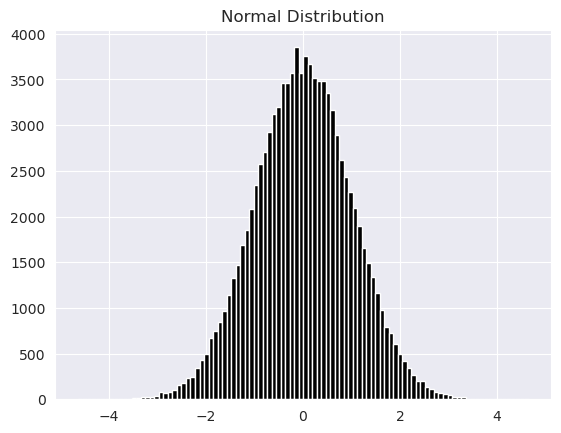

In [ ]:
probplot(x,plot=plt)
plt.title("Normal Distribution QQ Plot")


``` example
Text(0.5, 1.0, 'Normal Distribution QQ Plot')
```

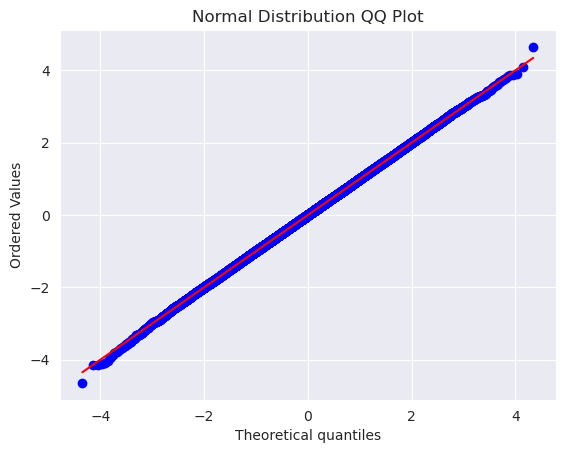

As a preliminary look, we can look at the distribution of daily returns.

In [ ]:
f,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].hist(log_returns,bins=100)
ax[0].set_title("Logdaily Returns")
ax[0].set_xlabel("Log Return")
ax[0].set_ylabel("Observations")
ax[0].set_xlim((-0.1,0.1))
probplot(log_returns,plot=ax[1])


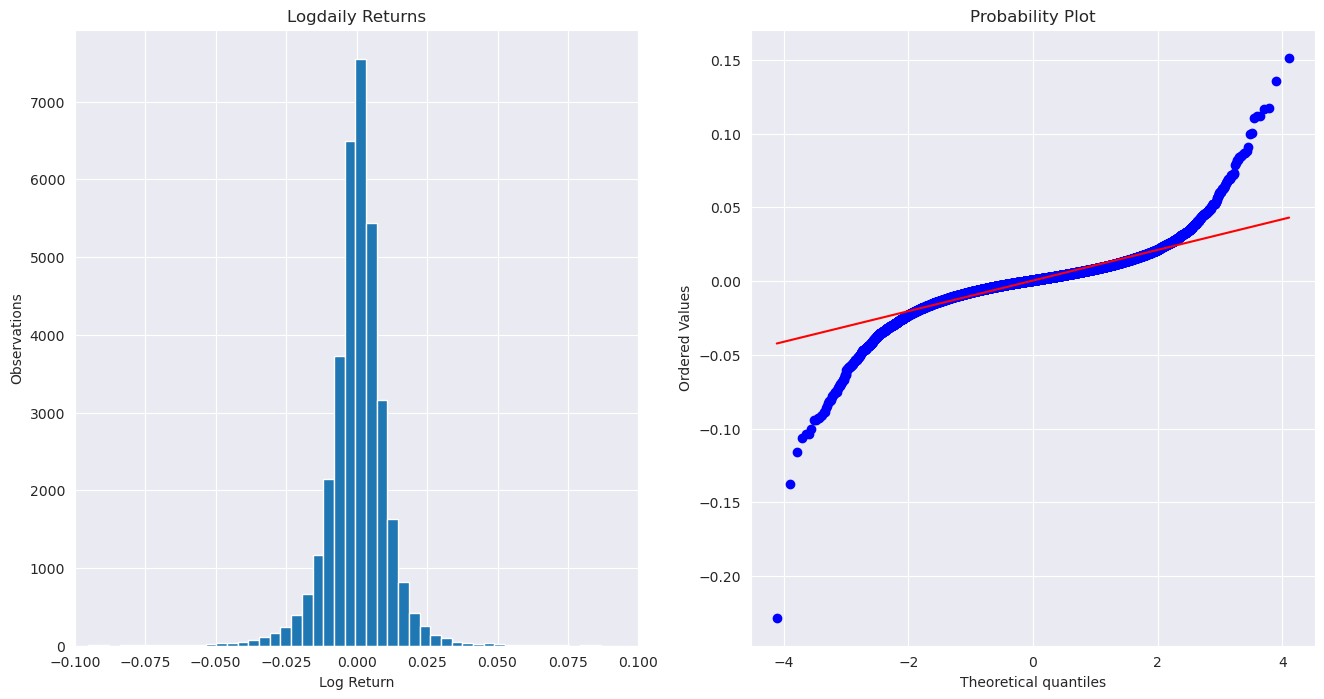

Compared to our control plots, the distributions is far from normal,
particularly from the tail ends. We can more thoroughly investigate the
outliers.

In [ ]:
sns.boxplot(log_returns)
plt.title("S&P500 Logdaily Returns")


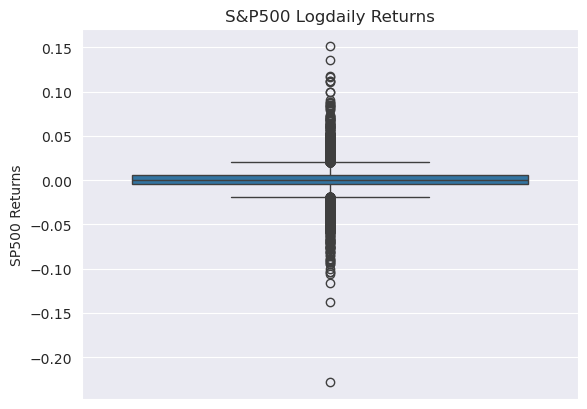

The vast majority of the log return values seem to lie in the interval
$(-0.05,0.05)$. This is the range we will inspect.

In [ ]:
clamped=pd.DataFrame(log_returns[(log_returns <= 0.05) & (log_returns >= -0.05) ])
clamped = clamped["SP500 Returns"]
f,ax = plt.subplots(1,2,figsize=(16,8))
ax[0].hist(clamped,bins=100)
ax[0].set_title("Logdaily Returns in [-0.05,0.05]")
ax[0].set_xlabel("Log Return")
ax[0].set_ylabel("Observations")
ax[0].set_xlim((-0.05,0.05))
probplot(clamped,plot=ax[1])


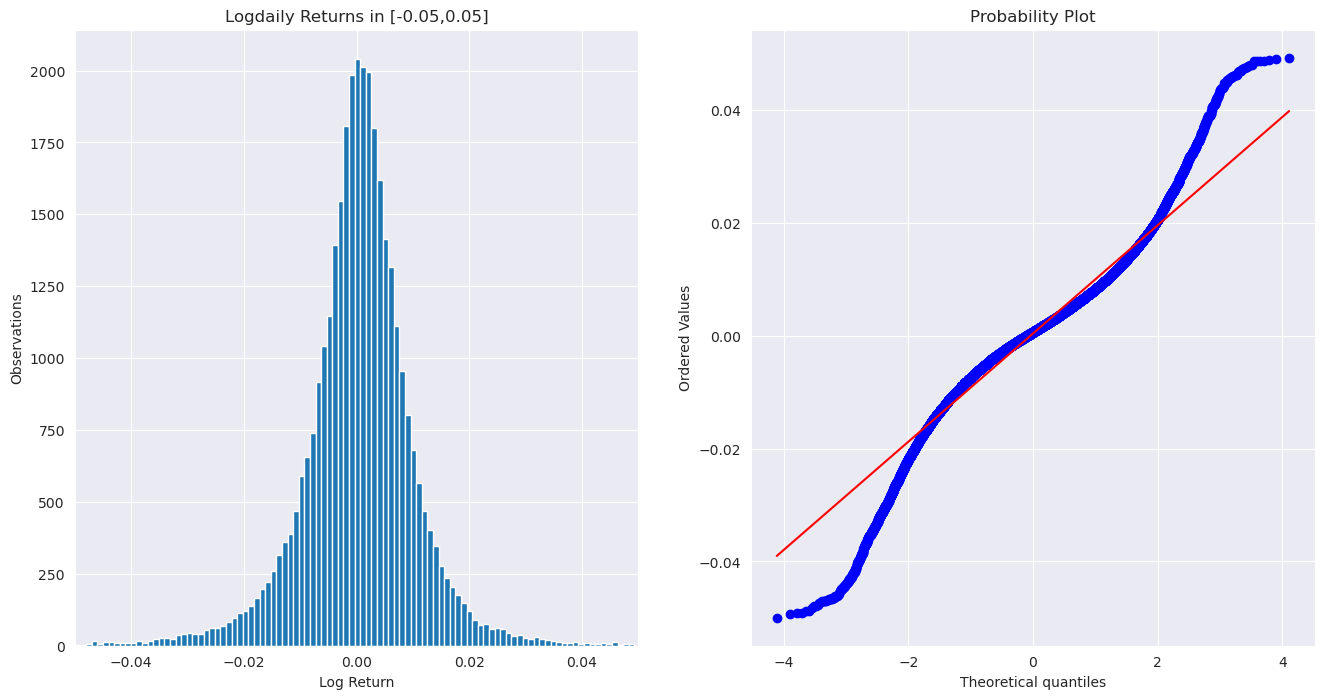

Despite the good looking histogram, the probability plot says otherwise,
the data are not normally distributed even when focusing on a small
interval of log returns.

Let's take a look at some other stocks' total history of returns.

In [ ]:
ko = csv_to_series("./KO.csv")
log_ko = np.log(1+ko["KO Returns"]).dropna()
log_gis = np.log(1+csv_to_series("./GIS.csv")["GIS Returns"]).dropna()
log_xlu = np.log(1+csv_to_series("./XLU.csv")["XLU Returns"]).dropna()
log_mcd = np.log(1+csv_to_series("./MCD.csv")["MCD Returns"]).dropna()
log_dfsvx = np.log(1+csv_to_series("../MiniProject1/DFSVX-returns.csv")["DFSVX Returns"]).dropna()
log_disvx = np.log(1+csv_to_series("../MiniProject1/DISVX-returns.csv")["DISVX Returns"]).dropna()
all_stocks = pd.concat([log_returns,log_ko,log_gis,log_mcd,log_dfsvx,log_disvx],axis=1)
tickers = ["S&P 500","KO","GIS","MCD","DFSVX","DISVX"]
all_stocks = all_stocks.set_axis(tickers, axis=1)


In [ ]:
import seaborn as sns
n = len(tickers)

for (i,k) in enumerate(tickers):
    f,ax = plt.subplots(1,2,figsize=(20,4))
    ax[0].set_title(f"{k} Logdaily Returns")
    ax[0].set_xlabel(f"Log Return")
    ax[0].set_ylabel("Observations")
    ax[0].set_xlim((-0.1,0.1))
    sns.histplot(all_stocks[k].dropna(),ax=ax[0])
    probplot(all_stocks[k].dropna(),plot=ax[1])
    ax[1].set_title(f"{k} Probability Plot")
    plt.show()



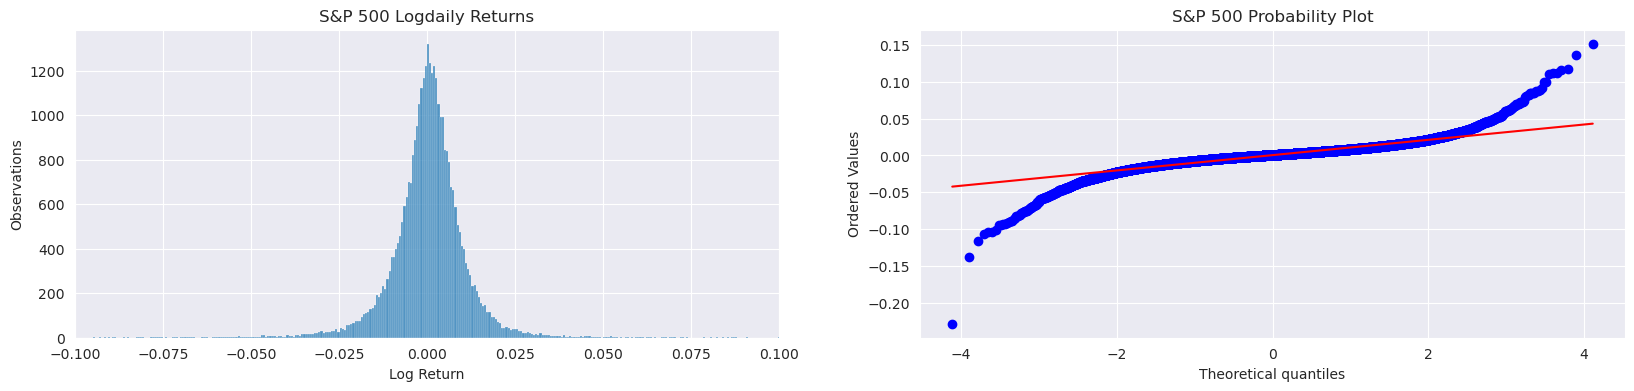
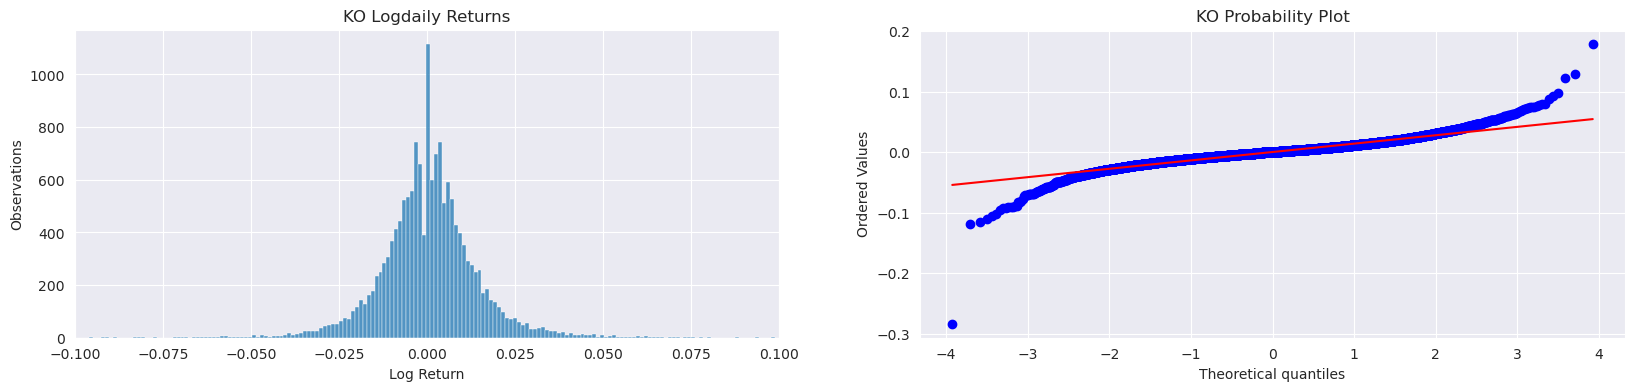
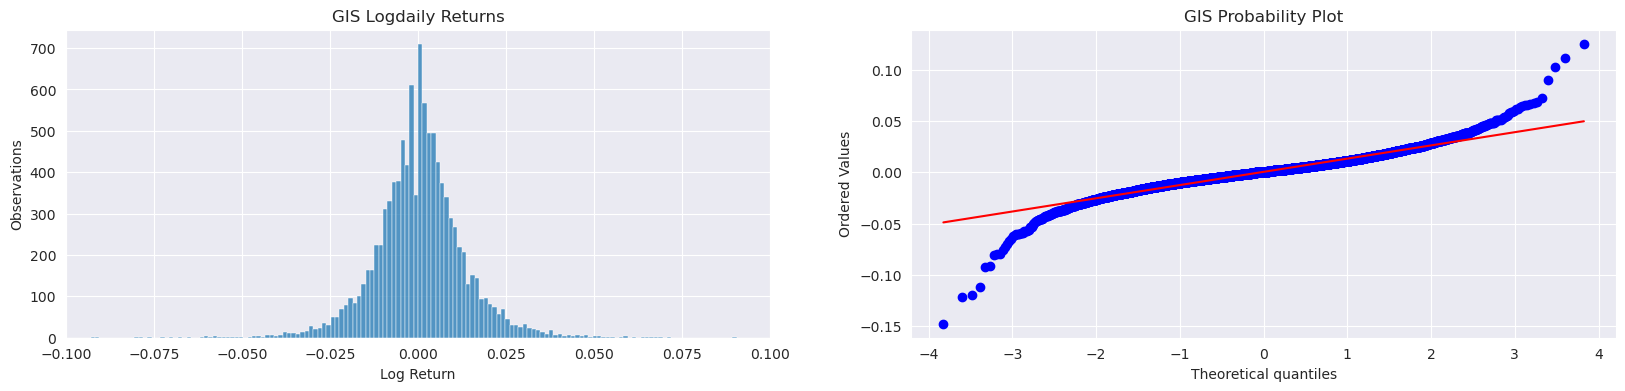
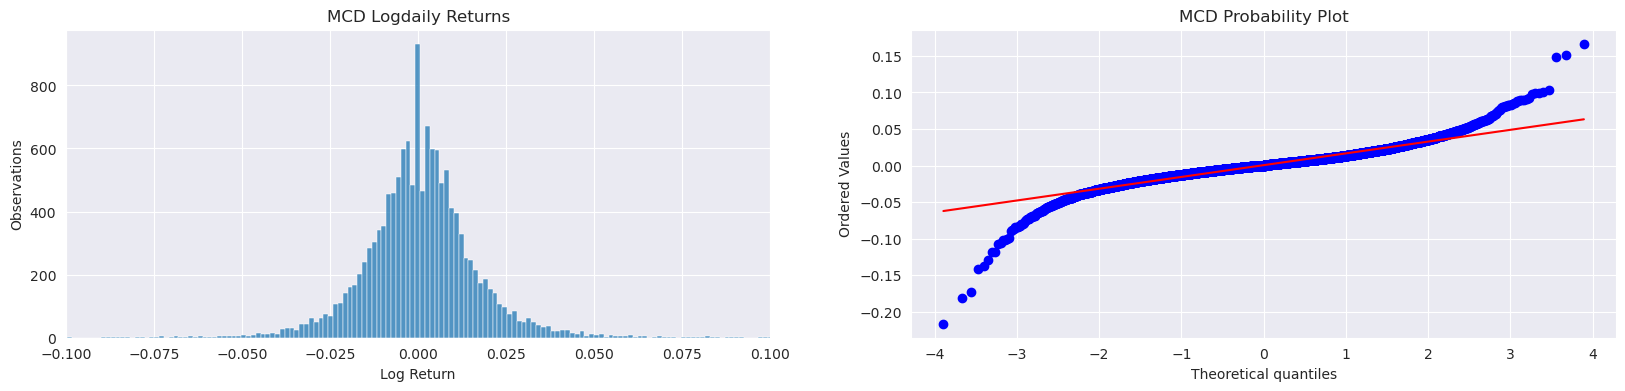
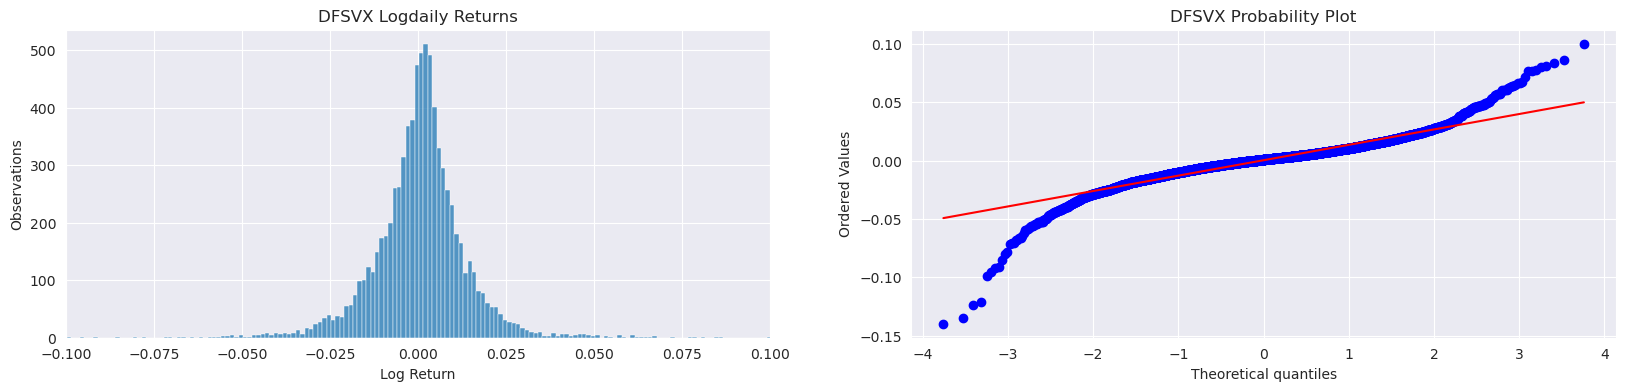
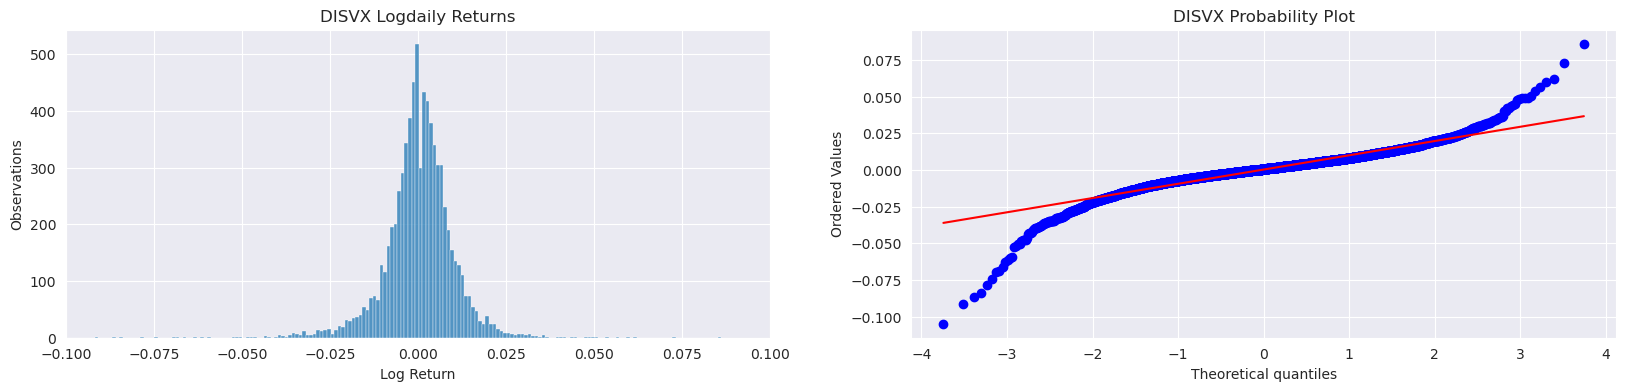

Though the distributions look somewhat clean, the probability plots
indicate deviation around the tails. KO looks to display the closest
behavior to normality among the stocks chosen.

# Formal Tests for Normality

So far, our tests for normality has been heuristic in nature. There are
formal tests for normality such as she Shapiro-Wilk test, which we can
employ. Below is the resulting $p$ values extracted from the test, where
the null hypothesis is that the data are normally distributed.

In [ ]:
from scipy.stats import shapiro, normaltest
names = ["Logdaily", "Logweekly","Logmonthly","Logyearly"]

weekly_logs = all_stocks.groupby(pd.Grouper(freq="W-MON")).agg("sum")
monthly_logs = all_stocks.groupby(pd.Grouper(freq="ME")).agg("sum")
yearly_logs = all_stocks.groupby(pd.Grouper(freq="YE")).agg("sum")

vars = [all_stocks,weekly_logs,monthly_logs,yearly_logs]
results = {"Ticker":tickers}
results.update({time: shapiro(var,axis=0,nan_policy='omit')[1] for time,var in zip(names,vars)})

shap_results = pd.DataFrame(data=results)
shap_results.set_index("Ticker")


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Logdaily</th>
      <th>Logweekly</th>
      <th>Logmonthly</th>
      <th>Logyearly</th>
    </tr>
    <tr>
      <th>Ticker</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>S&amp;P 500</th>
      <td>3.818544e-93</td>
      <td>1.133519e-52</td>
      <td>1.163160e-28</td>
      <td>2.120483e-04</td>
    </tr>
    <tr>
      <th>KO</th>
      <td>1.859133e-66</td>
      <td>3.983645e-74</td>
      <td>5.771239e-44</td>
      <td>3.938358e-14</td>
    </tr>
    <tr>
      <th>GIS</th>
      <td>1.312791e-53</td>
      <td>4.232199e-83</td>
      <td>3.605169e-49</td>
      <td>9.240974e-17</td>
    </tr>
    <tr>
      <th>MCD</th>
      <td>3.644711e-63</td>
      <td>1.821012e-78</td>
      <td>1.682117e-45</td>
      <td>7.616876e-16</td>
    </tr>
    <tr>
      <th>DFSVX</th>
      <td>6.241495e-56</td>
      <td>7.526820e-89</td>
      <td>2.851575e-55</td>
      <td>3.960046e-18</td>
    </tr>
    <tr>
      <th>DISVX</th>
      <td>2.801857e-54</td>
      <td>1.195344e-89</td>
      <td>5.262735e-56</td>
      <td>3.336761e-19</td>
    </tr>
  </tbody>
</table>
</div>

In every performance of the Shapiro-Wilk test, the resulting $p$ value
is decidedly below $0.05$, so in every case we reject the null
hypothesis that the data are normally distributed.

On the other hand, the `normaltest` from `scipy.stats` uses skewness and
kurtosis to compare against a normal distribtution.

In [ ]:
normal_results = {"Ticker":tickers}
normal_results.update({time: normaltest(var,axis=0,nan_policy='omit')[1] for time,var in zip(names,vars)})

normal_results = pd.DataFrame(data=normal_results)
normal_results.set_index("Ticker")


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Logdaily</th>
      <th>Logweekly</th>
      <th>Logmonthly</th>
      <th>Logyearly</th>
    </tr>
    <tr>
      <th>Ticker</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>S&amp;P 500</th>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.745658e-72</td>
      <td>5.742050e-06</td>
    </tr>
    <tr>
      <th>KO</th>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.499141e-72</td>
      <td>1.681979e-07</td>
    </tr>
    <tr>
      <th>GIS</th>
      <td>0.0</td>
      <td>0.0</td>
      <td>6.248636e-71</td>
      <td>2.118837e-13</td>
    </tr>
    <tr>
      <th>MCD</th>
      <td>0.0</td>
      <td>0.0</td>
      <td>1.698201e-64</td>
      <td>1.974224e-13</td>
    </tr>
    <tr>
      <th>DFSVX</th>
      <td>0.0</td>
      <td>0.0</td>
      <td>6.168767e-202</td>
      <td>1.172188e-12</td>
    </tr>
    <tr>
      <th>DISVX</th>
      <td>0.0</td>
      <td>0.0</td>
      <td>6.035076e-179</td>
      <td>4.315898e-10</td>
    </tr>
  </tbody>
</table>
</div>

In actuality, the formal tests aren't very applicable here. Hypothesis
testing with large amounts of data ($n > 300$) becomes extremely
sensitive to small deviations against the null hypothesis In our case,
this manifests itself in extremely small $p$ values, and warnings raised
with the testing functions that these $p$ values may be innacurate. With
large amounts of data, it becomes feasible to check things visually on
QQ plots and histograms, which we did and concluded deviation from
normality anyway.

# Testing Particular Bull Markets

We can selectively pick periods of time where volatility is typically
lower, which typically happens during bull markets We first examine the
longest bull market in US history: the period between December 1987 and
March 2000

In [ ]:
start, end = ("1987-12-01","2000-03-01")
for (i,k) in enumerate(tickers):
    f,ax = plt.subplots(1,2,figsize=(20,4))
    ax[0].set_title(f"{k} Logdaily Returns 1988-2000")
    ax[0].set_xlabel(f"Log Return")
    ax[0].set_ylabel("Observations")
    ax[0].set_xlim((-0.1,0.1))
    sns.histplot(all_stocks[k][start:end].dropna(),ax=ax[0])
    probplot(all_stocks[k][start:end].dropna(),plot=ax[1])
    ax[1].set_title(f"{k} Probability Plot")
    plt.show()


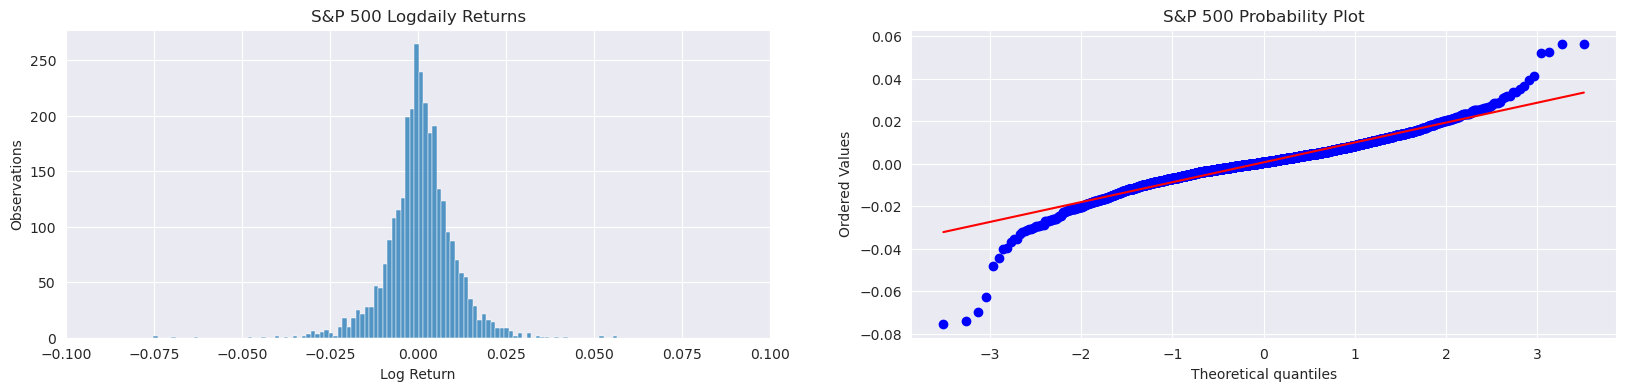
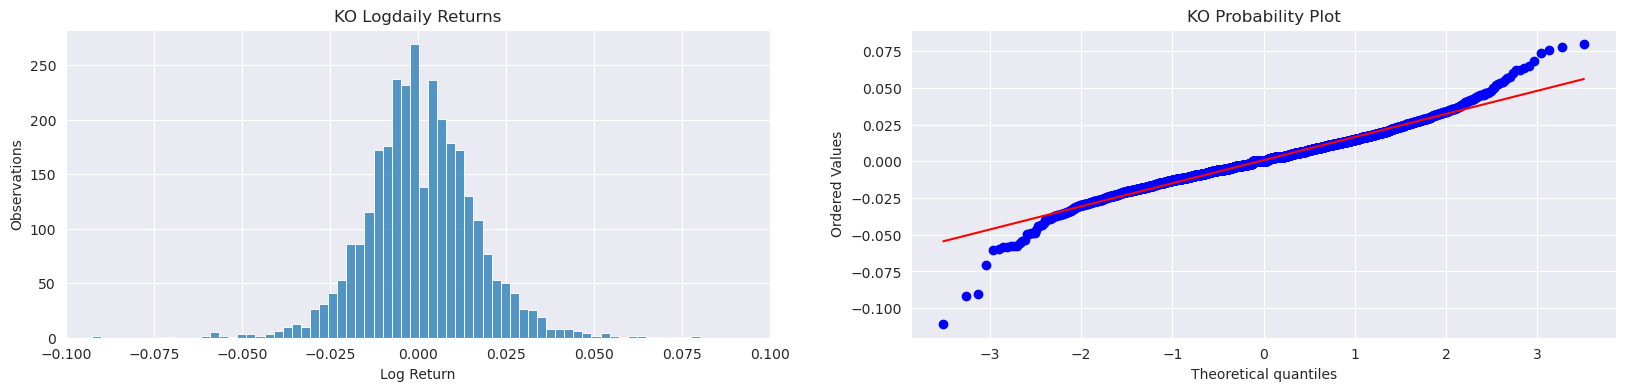
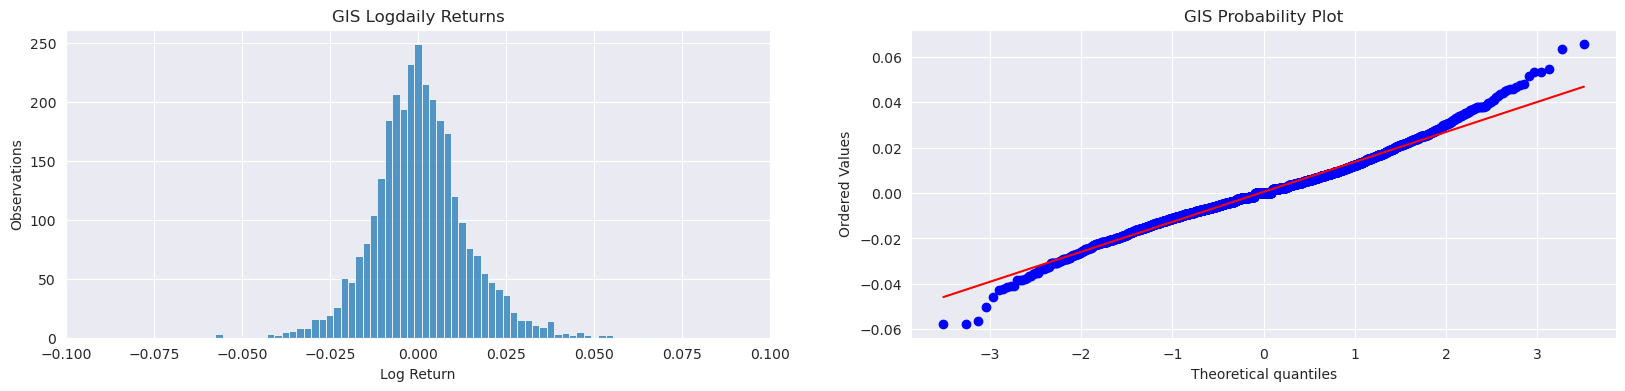
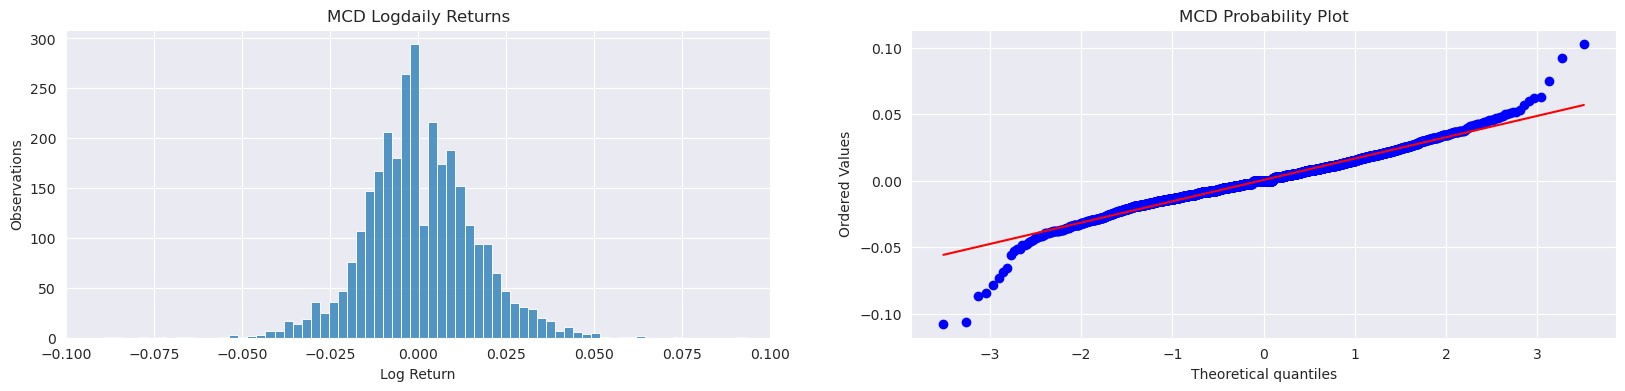
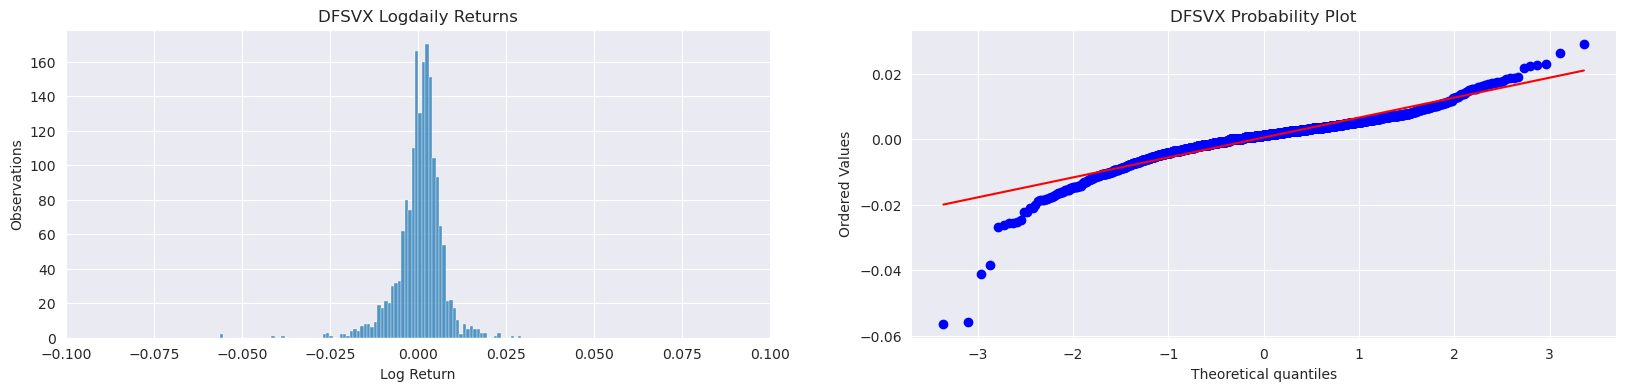
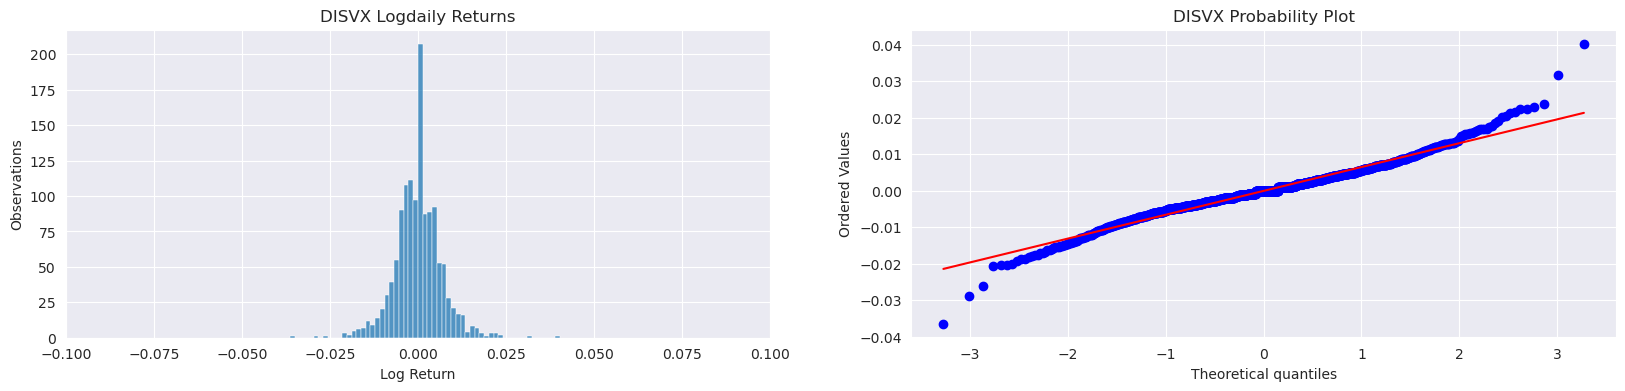

Though the asset wasn't around for the full period, DISVX and GIS show
improvements in their QQ plots, indicating this period might show signs
of normal returns.

In [ ]:
bull_results = {"Ticker":tickers}
bull_results.update({time: shapiro(var[start:end],axis=0,nan_policy='omit')[1] for time,var in zip(names,vars)})

bull_results = pd.DataFrame(data=bull_results)
bull_results.set_index("Ticker")


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Logdaily</th>
      <th>Logweekly</th>
      <th>Logmonthly</th>
      <th>Logyearly</th>
    </tr>
    <tr>
      <th>Ticker</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>S&amp;P 500</th>
      <td>5.281631e-33</td>
      <td>1.608250e-13</td>
      <td>0.001171</td>
      <td>0.533628</td>
    </tr>
    <tr>
      <th>KO</th>
      <td>2.794090e-29</td>
      <td>1.088972e-11</td>
      <td>0.149627</td>
      <td>0.621777</td>
    </tr>
    <tr>
      <th>GIS</th>
      <td>1.024150e-33</td>
      <td>2.745457e-08</td>
      <td>0.028857</td>
      <td>0.041571</td>
    </tr>
    <tr>
      <th>MCD</th>
      <td>1.011819e-29</td>
      <td>5.083932e-08</td>
      <td>0.344817</td>
      <td>0.613485</td>
    </tr>
    <tr>
      <th>DFSVX</th>
      <td>2.551790e-29</td>
      <td>2.564002e-07</td>
      <td>0.199569</td>
      <td>0.207291</td>
    </tr>
    <tr>
      <th>DISVX</th>
      <td>1.175701e-28</td>
      <td>5.759110e-06</td>
      <td>0.006312</td>
      <td>0.608427</td>
    </tr>
  </tbody>
</table>
</div>

The logmonthly returns appear to show possible signs of normality, and
this possibility only increases as you expand your time horizon.

It is quite difficult to find periods of time where the log returns show
any evidence at all of being normally distributed, and
$3+13\ast 12 = 159$ logmonthly observations in this period would
normally be enough to provide evidence against normality, but this
particular bull market seems to show promise.

Let us investigate the second longest bull market spanning from March
2009 to February 2020.

In [ ]:
start, end = ("2009-03-01", "2020-02-01")
bull2_results = {"Ticker":tickers}
bull2_results.update({time: shapiro(var[start:end],axis=0,nan_policy='omit')[1] for time,var in zip(names,vars)})

bull2_results = pd.DataFrame(data=bull_results)
bull2_results.set_index("Ticker")


<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Logdaily</th>
      <th>Logweekly</th>
      <th>Logmonthly</th>
      <th>Logyearly</th>
    </tr>
    <tr>
      <th>Ticker</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>S&amp;P 500</th>
      <td>5.281631e-33</td>
      <td>1.608250e-13</td>
      <td>0.001171</td>
      <td>0.533628</td>
    </tr>
    <tr>
      <th>KO</th>
      <td>2.794090e-29</td>
      <td>1.088972e-11</td>
      <td>0.149627</td>
      <td>0.621777</td>
    </tr>
    <tr>
      <th>GIS</th>
      <td>1.024150e-33</td>
      <td>2.745457e-08</td>
      <td>0.028857</td>
      <td>0.041571</td>
    </tr>
    <tr>
      <th>MCD</th>
      <td>1.011819e-29</td>
      <td>5.083932e-08</td>
      <td>0.344817</td>
      <td>0.613485</td>
    </tr>
    <tr>
      <th>DFSVX</th>
      <td>2.551790e-29</td>
      <td>2.564002e-07</td>
      <td>0.199569</td>
      <td>0.207291</td>
    </tr>
    <tr>
      <th>DISVX</th>
      <td>1.175701e-28</td>
      <td>5.759110e-06</td>
      <td>0.006312</td>
      <td>0.608427</td>
    </tr>
  </tbody>
</table>
</div>

The results show largely the same trends, with the minutae differing
slightly. Out of interest, we plot the distributions and QQ plots of
this bull market as well.

In [ ]:
for (i,k) in enumerate(tickers):
    f,ax = plt.subplots(1,2,figsize=(20,4))
    ax[0].set_title(f"{k} Logdaily Returns 2009-2020")
    ax[0].set_xlabel(f"Log Return")
    ax[0].set_ylabel("Observations")
    ax[0].set_xlim((-0.1,0.1))
    sns.histplot(all_stocks[k][start:end].dropna(),ax=ax[0])
    probplot(all_stocks[k][start:end].dropna(),plot=ax[1])
    ax[1].set_title(f"{k} Probability Plot")
    plt.show()


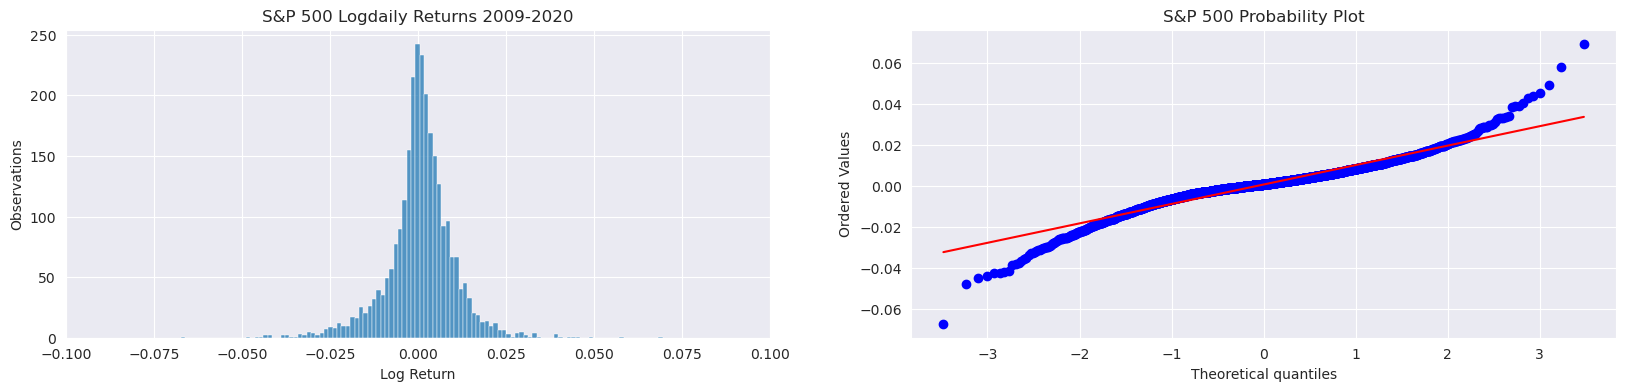
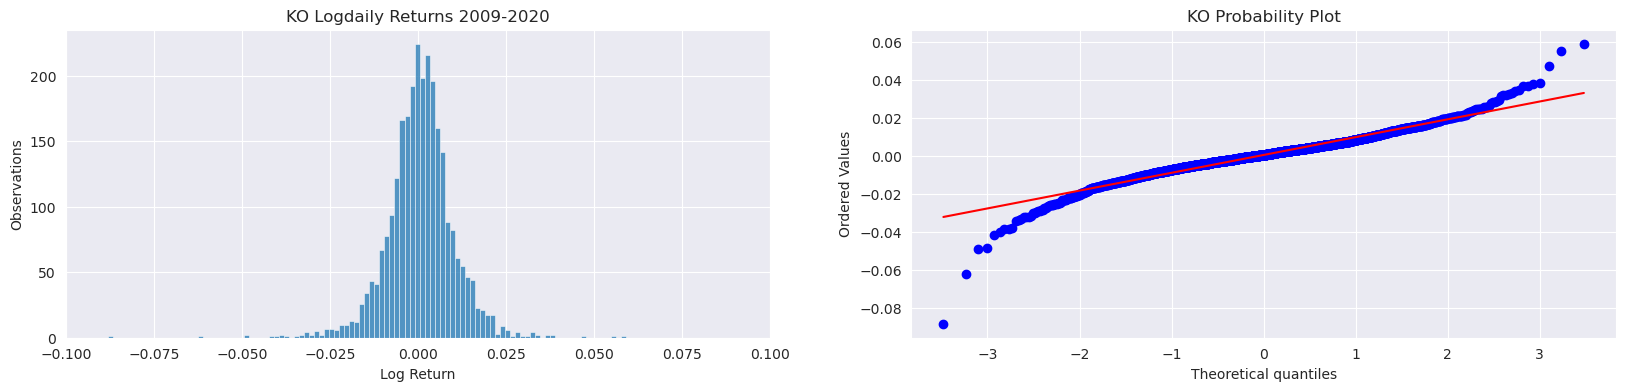
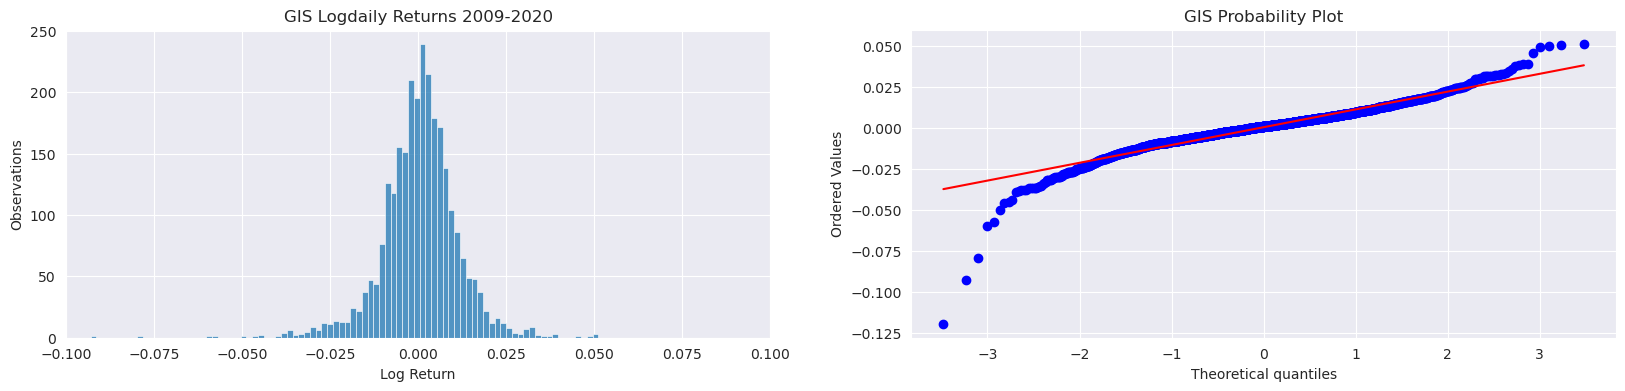
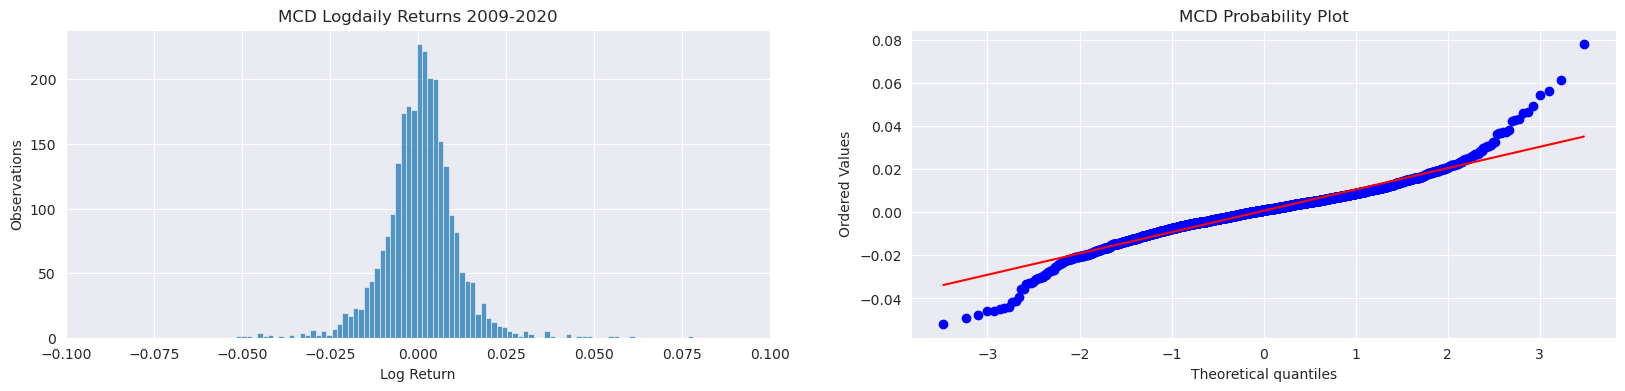
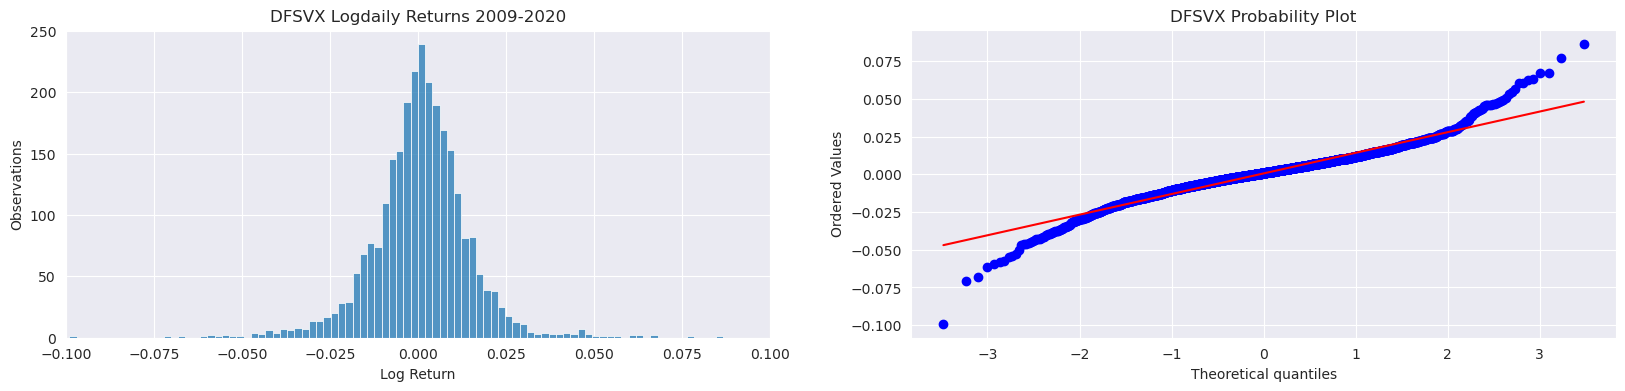
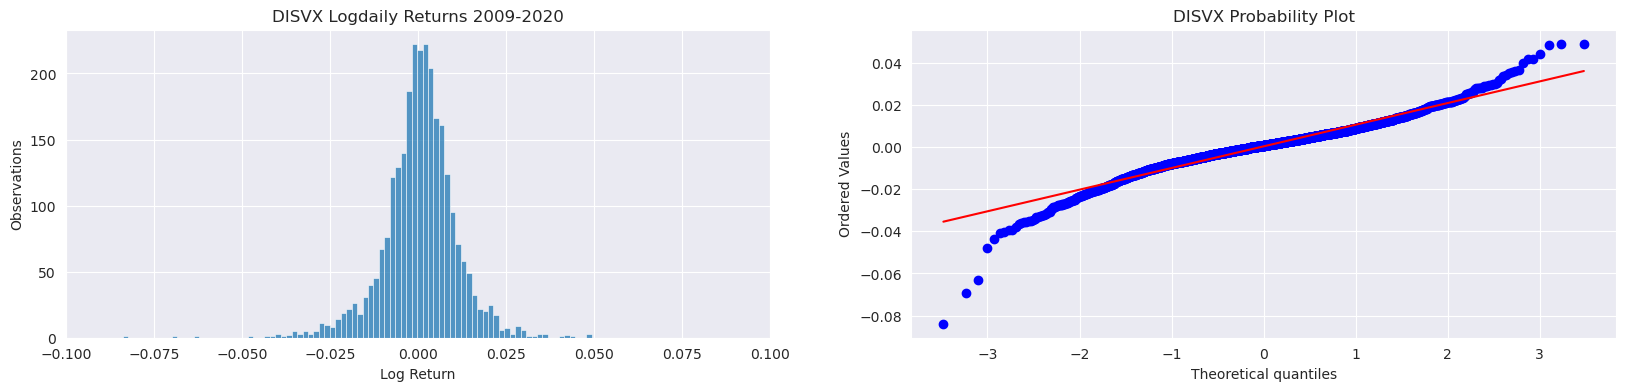

# Individual Stocks

We should not expect it to be easy to construct a portfolio of stocks
(i.e. equities) with lognormal returns over a significant period of
time. Equities are inherently riskier than other financial assets like
bonds, and show fatter tails in distributions of historical returns on
virtually all time scales. One typically reduces the volatility of a
portfolio of stocks by allocating to "safer" kinds of stocks (e.g.
consumer staples, utilities) or by moving away from stocks altogether
and using bonds. Since we are interested in stocks only, we will work
within the confines of equities.

We hypothesize that a diverse portfolio is the wrong way to mine
logreturns that might be normal. Instead, we look at a particular
individual stock in the consumer staple sector, Coca-Cola (KO).

In [ ]:
np.log(ko["KO"]).plot(title="KO Logvalue: $10000 Invested",
                      ylabel = "Logvalue")


``` example
<Axes: title={'center': 'KO Logvalue: $10000 Invested'}, xlabel='Date', ylabel='Logvalue'>
```

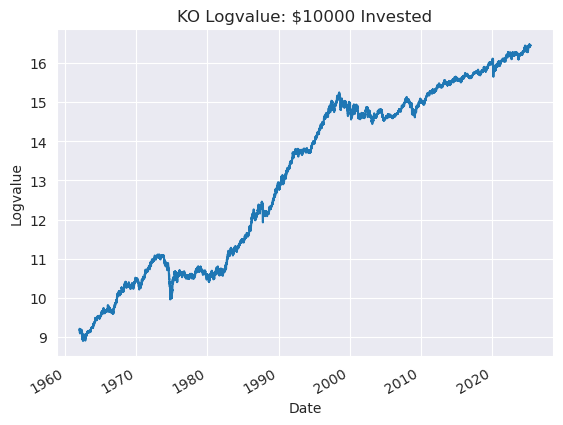

From a visual inspection of the logvalue of an investment in KO, we see
that the period between 1995 and 1996 shows promise for lognormal
returns, based on intuition alone. The reason is the log price seems to
dither around the same price, indicating a more normal random choice of
up-down movements on the day. We should want more zero-mean log returns
to have any hope of finding such a period with normally distributed
returns.

In [ ]:
s1,s2 = ("1995-04-01","1996-04-01")

probplot(log_ko[s1:s2],plot=plt)
plt.title(f"KO logdaily returns: {s1}—{s2}")
plt.show()


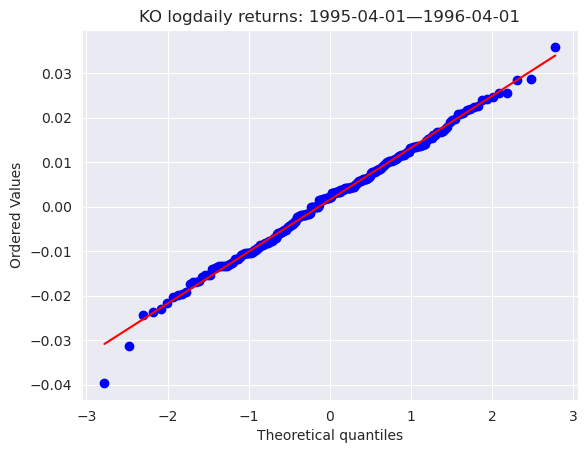

In [ ]:
f,ax = plt.subplots(1,2,figsize=(16,8))
sns.histplot(log_ko[s1:s2],ax=ax[0],kde=True)
probplot(log_ko[s1:s2],plot=ax[1])
plt.show()


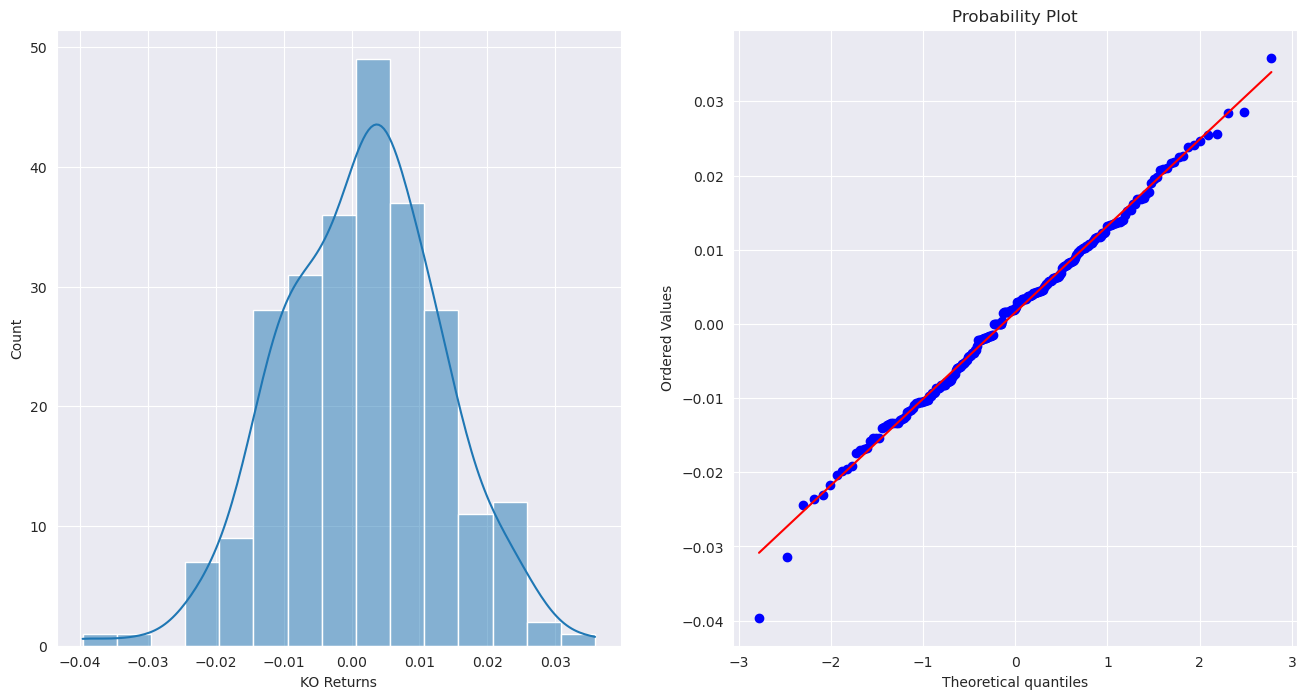

Apart from the distribution and QQ plot of logdaily returns looking more
favorable than our other assets, we can check with a rigorous hypothesis
test:

In [ ]:
print(f"KO logreturns 04/1995-04/1996 p-value: {normaltest(log_ko[s1:s2])[1]}")


``` example
KO logreturns 04/1995-04/1996 p-value: 0.5050793770779156
```

During the period of 04/1995 to 04/1996, we observe there is not enough
evidence to reject the null hypothesis that the data is not normally
distributed.

# Normality as a Function of Length of Time Period

In the previous section we found a yearly period where a test of
normaliy on the logdaily returns of KO did not show enough evidence to
reject the null hypothesis of normal distributivity. Here we investigate
the relationship of this $p$ value with the period of time we look over.

We will test this by testing normality of logdaily returns on the S&P
500 for rolling monthly, semiannual, yearly, 2-yearly, and 5-yearly
trading periods. In each of these rolling periods, we will test for
normality, and see in what percentage of these rolling periods we can
reject the null hypothesis.

In [ ]:
periods = [20,6*20, 252,2*252,5*252]
period_names = ["Monthly","Semiannual","Yearly","2-year","5-year"]

percent_rejected = []
for x in periods:
    rolled_ps = log_returns.rolling(x).apply(lambda x:normaltest(x)[1]).dropna()
    percent_normal = 100* len(rolled_ps[rolled_ps< 0.05]) / len(rolled_ps)
    percent_rejected.append(percent_normal)



In [ ]:
sns.barplot(x=period_names,y=percent_rejected)
plt.title("% Rejection of Normality. Rolling Periods of Logdaily S&P500 Returns")
plt.show()


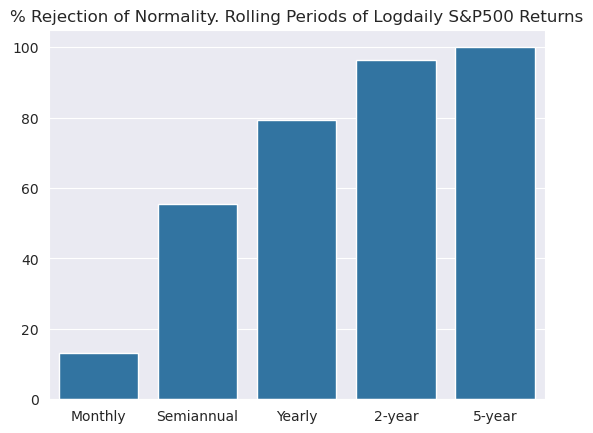
The graph gives an interpretation as follows: **given any particular
yearly period of logdaily S&P500 returns, there is a ~80% chance that
this period shows enough evidence to reject the hypothesis that the data
are normally distributed.** In other words, only 20% of rolling yearly
periods of logdaily returns show potential to be normally distributed.
Chances of finding potential for normality increase as your time window
shrinks.

We can run the same examination on KO to see how they differ, if at all.

In [ ]:
periods = [20,6*20, 252,2*252,5*252]
period_names = ["Monthly","Semiannual","Yearly","2-year","5-year"]
ko_percent_rejected = []
for x in periods:
    rolled_ps = log_ko.rolling(x).apply(lambda x:normaltest(x)[1]).dropna()
    ko_percent_normal = 100* len(rolled_ps[rolled_ps< 0.05]) / len(rolled_ps)
    ko_percent_rejected.append(ko_percent_normal)

sns.barplot(x=period_names,y=ko_percent_rejected)
plt.title("% Rejection of Normality. Rolling Periods of Logdaily KO Returns")


``` example
Text(0.5, 1.0, '% Rejection of Normality. Rolling Periods of Logdaily KO Returns')
```

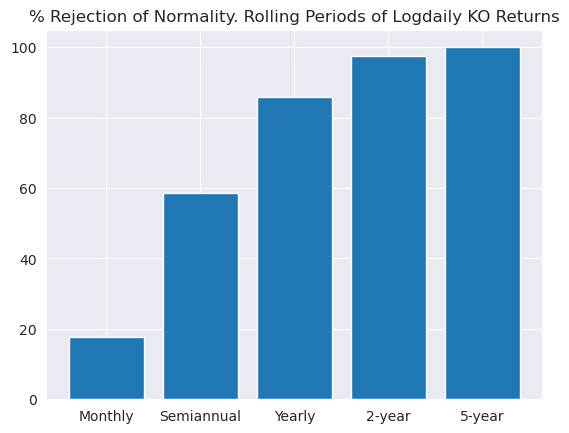

And we can run it on a few more low beta stocks/indexes to see a trend:

In [ ]:
log_gis = np.log(1+csv_to_series("./GIS.csv")["GIS Returns"]).dropna()
log_xlu = np.log(1+csv_to_series("./XLU.csv")["XLU Returns"]).dropna()
log_mcd = np.log(1+csv_to_series("./MCD.csv")["MCD Returns"]).dropna()

def reject_normality(ticker, returns):
    periods = [20,6*20, 252,2*252,5*252]
    period_names = ["Monthly","Semiannual","Yearly","2-year","5-year"]
    percent_rejected = []
    for x in periods:
        rolled_ps = returns.rolling(x).apply(lambda x:normaltest(x)[1]).dropna()
        percent_normal = 100* len(rolled_ps[rolled_ps< 0.05]) / len(rolled_ps)
        percent_rejected.append(percent_normal)


    plt.bar(x=period_names,height=percent_rejected)
    plt.xlabel("Rolling Period")
    plt.title(f"% Rejection of Normality. Rolling Periods of Logdaily {ticker} Returns")
    plt.show()


In [ ]:
reject_normality("XLU",log_xlu)
reject_normality("GIS",log_gis)
reject_normality("MCD",log_mcd)


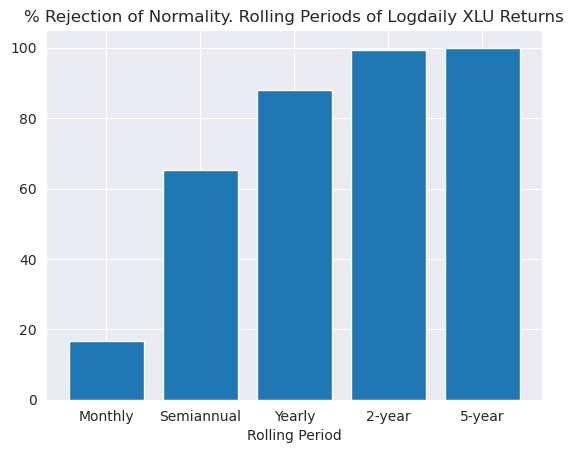
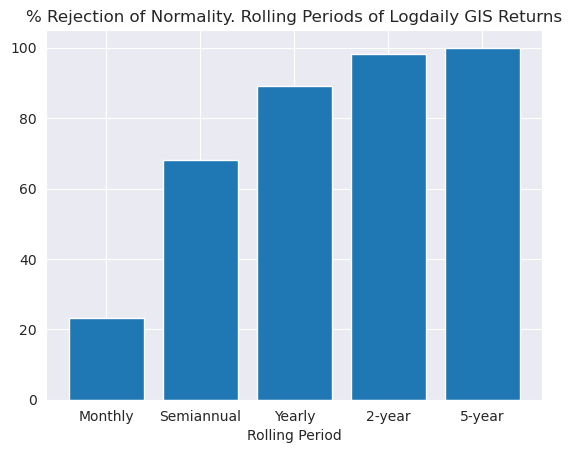
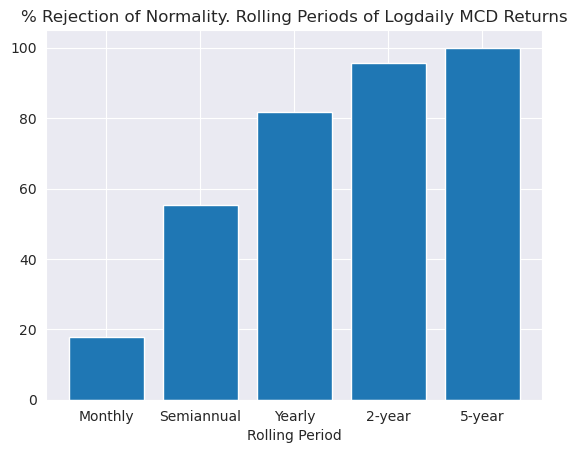

The graphs show a consistent trend that **longer periods of logdaily
returns display less liklihood of being normally distributed.** Thus,
finding periods of normally distributed returns has less to do with the
idiosyncrasies of each stock/index, and more to do with how the test
actually works. In particular, we can reasonably guess that the lack of
evidence of normality in the shorter time windows is very likely due to
the lack of data points, and not an actual statement about the intrinsic
data itself.

# Testing Project 1 Portfolio

In [ ]:
inception = "1994-12-29"
disvx = csv_to_series("../MiniProject1/DISVX-returns.csv")["DISVX Returns"]
dfsvx = csv_to_series("../MiniProject1/DFSVX-returns.csv")["DFSVX Returns"]
vti = csv_to_series("../MiniProject1/VTI-returns.csv")["VTI Returns"]
vxus = csv_to_series("../MiniProject1/VXUS-returns.csv")["VXUS Returns"]
govt = csv_to_series("../MiniProject1/GOVT-returns.csv")["GOVT Returns"]
zroz = csv_to_series("../MiniProject1/ZROZ-returns.csv")["ZROZ Returns"]
p2 = 0.28*vti[inception:] + 0.27*dfsvx[inception:] + 0.18*vxus[inception:] + 0.17*disvx[inception:] + 0.10*zroz[inception:]


In [ ]:
log_p = np.log(1+p2)
reject_normality("P1 Portfolio", log_p)


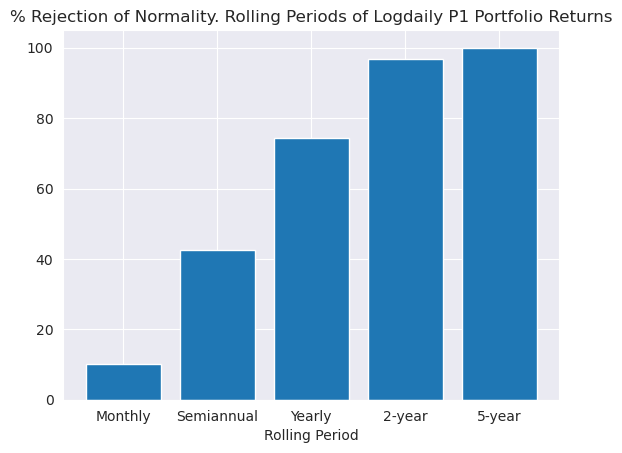

Interestingly, the high risk portfolio from my first project show more
yearly periods with promising signs of normally distributed returns,
moreso than even our most "normal" stock choice KO. The difference is
especially stark in the semiannual period, where over half the analyzed
rolling periods did not produce enough evidence to reject normality.

# Conclusion

In all of our tested data, between 40%-65% of any contiguous semiannual
periods of historical logdaily returns showed enough evidence to reject
the notion that returns are normally distributed. ~80%+ of contiguous
yearly windows of logdaily returns show strong evidence against
normality, with that number increasing as you look for longer windows.
In other words, searching for normally distributed returns over any
significant period of time is a coin flip at best, or a losing game at
worst (in our data at least).

We can conclude that finding normally distributed returns over long
periods of time is **essentially an exercise in arbitrary data mining**,
and the pattern fails far more often than it succeeds. Though, this is
the point of this exercise: the assumption of normal stock returns in
various financial models such as Black-Scholes is not borne out in
reality, and this illustrates that plainly. The essence of assuming
lognormal returns is simply a convenience to find closed form solutions
to option prices, and models incorporating assumptions that reflect
reality are much more difficult to work with, requiring simulation and
the analysis in limiting cases to determine a good enough answer.
Assumptions of normality—at best—hold on small time scales, perhaps an
investigation into intraday or even intrahour price action could give
something more fruitful.